<a href="https://colab.research.google.com/github/s-rishu/predicting-earthquake-damage/blob/main/predicting_damage_grade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Loading Data**
---
We're going to use a building structure and building ownership and use data set which contains earthquake damage data on buildings from 11 earthquake districts in Nepal during 2015 earthquake. 

The target variables is `damage_grade` and is equal Grade 1. Grade 2, Grade 3, Grade 4 or Grade 5 based on damage level of the building. The primary key of our data woulad be the `building_id` which is unique for each building instance.

In [ ]:
#load data
import pandas as pd
structure_data = pd.read_csv('csv_building_structure.csv', index_col='building_id', dtype={'building_id': object})
use_data = pd.read_csv('csv_building_ownership_and_use.csv', index_col='building_id', dtype={'building_id': object})
print(structure_data.shape)
print(use_data.shape)
print(structure_data.dtypes)
print(use_data.dtypes)
#print(vdcmun_loc_data.columns)

(762106, 30)
(762106, 16)
district_id                                int64
vdcmun_id                                  int64
ward_id                                    int64
count_floors_pre_eq                        int64
count_floors_post_eq                       int64
age_building                               int64
plinth_area_sq_ft                          int64
height_ft_pre_eq                           int64
height_ft_post_eq                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     

## **Removing columns that can cause data leaks**
---
These columns were collected post earthquake and won't be available to us at the time of model deployment. Hence, they should be removed.:

In [ ]:
#removing post earthquake collected data as these might cause data "leak"
structure_data.drop(columns=['condition_post_eq', 'technical_solution_proposed', 'height_ft_post_eq', 'count_floors_post_eq'], inplace=True)


## **Joining the datasets**
---
The duplicate columns are dropped and thw two datasets are joined on `building_id` as the index column.

In [ ]:
#removing redundant columns
use_data.drop(columns=['district_id', 'vdcmun_id', 'ward_id'], inplace=True)

#join all datasets
data = structure_data.join(use_data)
#data = data.join(vdcmun_loc_data, on='vdcmun_id')


print(data.shape)

(762106, 39)


## **Removing instances with null values**
---
The number of records that will be removed are neglegible. And hence we don't need to worry about replacing the null values with proxy.

In [ ]:
print("Count of null values in target variable: {}".format(data['damage_grade'].isna().sum()))
print("Count of null values in entire dataset: {}".format(data.isna().sum().sum()))

#removing null values
data.dropna(inplace=True)
print(data.shape)

Count of null values in target variable: 12
Count of null values in entire dataset: 26
(762093, 39)


## **Simplifying the Target Variable**
---
We are mostly interested in the correct classification of `Grade 5` instances. Therefore we can simplify our target variable and reduce the count of possible class variables from 5 to 3. We also change the datatype to int to further facilitate our modelling.

In [ ]:
#reduce the number of target variable outcomes
y = 'damage_grade'
data.loc[data[y] == "Grade 1", y] = 1
data.loc[data[y] == "Grade 2", y] = 1
data.loc[data[y] == "Grade 3", y] = 2
data.loc[data[y] == "Grade 4", y] = 2
data.loc[data[y] == "Grade 5", y] = 3
#update the datatype
data[y] = data[y].astype(int)

## **Looking at data balance**
---
Below we visualize the distribution of each `damage_grade`. The data is not highly skewed, hence we can work with the current balance.

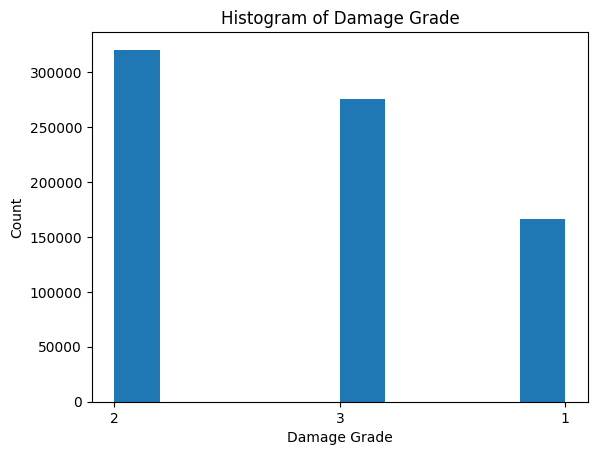

In [ ]:
#exploratory analysis
import matplotlib.pyplot as plt
# Create a histogram
plt.hist(data[y].astype(str))

# Set the title and labels
plt.title('Histogram of Damage Grade')
plt.xlabel('Damage Grade')
plt.ylabel('Count')

# Show the plot
plt.show()

## **Fixing datatypes of location variables**
---
The three feature describing the location of each building should not be numerical as there is no sense of order within the values. It is fit to be categorical.

In [ ]:
#fixing datatypes of categorical columns
cols_to_fix = ['district_id', 'vdcmun_id', 'ward_id']
for col in cols_to_fix:
  data[col] = data[col].astype(object)

print(data.dtypes)

district_id                                object
vdcmun_id                                  object
ward_id                                    object
count_floors_pre_eq                         int64
age_building                                int64
plinth_area_sq_ft                           int64
height_ft_pre_eq                            int64
land_surface_condition                     object
foundation_type                            object
roof_type                                  object
ground_floor_type                          object
other_floor_type                           object
position                                   object
plan_configuration                         object
has_superstructure_adobe_mud                int64
has_superstructure_mud_mortar_stone         int64
has_superstructure_stone_flag               int64
has_superstructure_cement_mortar_stone      int64
has_superstructure_mud_mortar_brick         int64
has_superstructure_cement_mortar_brick      int64


## **Drop columns containing redundant information**
---
The information contained in these columns is already present within other dummy variables associated with these. Hence we can drop them without affecting our data.

In [ ]:
#removing columns with redundant information
data.drop(columns=['has_secondary_use', 'has_superstructure_other'], inplace=True)

## **Analyzing categorical variables**
---

In [ ]:
#exploring categorical variables
for col in data.columns:
  if data.dtypes[col] == object:
    print("No of unique values for column {} is {}".format(col, len(pd.unique(data[col]))))

No of unique values for column district_id is 11
No of unique values for column vdcmun_id is 110
No of unique values for column ward_id is 945
No of unique values for column land_surface_condition is 3
No of unique values for column foundation_type is 5
No of unique values for column roof_type is 3
No of unique values for column ground_floor_type is 5
No of unique values for column other_floor_type is 4
No of unique values for column position is 4
No of unique values for column plan_configuration is 10
No of unique values for column legal_ownership_status is 4


## **Exploring location data features**


---
From our analysis below we conclude that 'ward_id' gives us all the information about the location and encompasses the information given by 'district_id' and 'vdcmun_id'. Infact 'ward_id' is just a concatanation of district, municipality and ward numbers.






In [ ]:
print(data[['ward_id', 'vdcmun_id', 'district_id']].head())
print("Unique set of location: {}".format(len(data.groupby(by=['ward_id', 'vdcmun_id', 'district_id']))))
print(data.groupby(by=['ward_id'])['district_id'].nunique().nunique())
print(data.groupby(by=['ward_id'])['vdcmun_id'].nunique().nunique())

             ward_id vdcmun_id district_id
building_id                               
120101000011  120703      1207          12
120101000021  120703      1207          12
120101000031  120703      1207          12
120101000041  120703      1207          12
120101000051  120703      1207          12
Unique set of location: 945
1
1


## **Feature Enginering of ward_id**


---



Since `ward_id` has 945 unique values and is not suitable to dummyize as this will create very large number of features. Additionally using `ward_id` directly as a predictor may give superficial information which may not hold when the model is deployed during occureance of future earthquakes. Therefore we will feature engineer this column into a more suitable numerical variable. The possible values for `damage_grade` are `{1, 2, 3}`. 

We will create 2 numerical columns for each `ward_id` corresponding to each possible damage grade i.e `pr_grade_2`, `pr_grade_3`. We don't create a column for `pr_grade_1` as it would be redundant and the value would just be `1 - pr_grade_2 - pr_grade_3`. For column `pr_grade_i`, the values will be the probability of a building having damage grade `i` given the corresponding `ward_id` of the building, i.e-

```Prob(grade=grade_i | ward=ward_i) = (No of buildings with grade=grade_i and ward=ward_i)/(Total no of buildings with ward=ward_i)```

Below is the code for same. This makes sense as it help us model the regional characteristics of each ward that might not have been included in the other features without having to create huge number of dummy features.




In [ ]:
#calculating total number of buildings for each ward_id
data['ward_id_agg'] = data.groupby(['ward_id']).transform('size')

data_groupby = data.groupby(['ward_id', 'damage_grade']).agg('size').rename('count').reset_index().set_index('ward_id')

#calculating total number of grade 2 buildings for each ward_id, grade 1 not needed as it would be redundant info
data = data.join(data_groupby[data_groupby['damage_grade']==2].rename(columns={'count': 'pr_grade_2'}).drop(columns=['damage_grade']), on='ward_id').fillna(0)

#calculating total number of grade 3 buildings for each ward_id
data = data.join(data_groupby[data_groupby['damage_grade']==3].rename(columns={'count': 'pr_grade_3'}).drop(columns=['damage_grade']), on='ward_id').fillna(0)

#calculating probabilities for each grade column
data['pr_grade_2'] = data['pr_grade_2'] / data['ward_id_agg']
data['pr_grade_3'] = data['pr_grade_3'] / data['ward_id_agg']

#dropping ward_id_agg and ward_id as it is no longer needed
data.drop(columns=['ward_id_agg'], inplace=True)

## **Proxying the Distance from Epicentre**
---
We don't have any data on distance from epicenter or the exact address of the building instances. But we believe that getting the distance from epicenter is necessary for building an unbiased model. Or else the model would be biased against the current epicenter and won't perform well during future occurances of earthquakes which occur at different epicenters.

### Proxy Logic
1. Approximate the location of each building with the location of it's municipality(`vdcmun_id`). This is done to make data collection easy yet be useful, using `ward_id` would be too fine grained and would require lot of manual work due to presence of huge number of wards in the data. And using `district_id` would be too broad so as to provide any real information. 

2. Get the latitude and longitude of the municipalities manually using Google Maps. This will roughly be taken at the mid point of each municipality.

3. Get the latitude and longitude of the epicenter of the earthquake. Since the data reflects the effect of two back-to-back earthquakes with two different epicenters, we will need the location of both the epicenters.

4. Use Haversine formula to get distance of each ward from each of the epicenter.

5. Take and average of the two distances and create the final feature column `dist_from_epi`.

In [ ]:
import math

#location of epicenter of april 15 earthquake
epicenter_lat = 28.231
epicenter_lon = 84.731

#location of epicenter of may 12 aftershock
epicenter_af_lat = 27.837
epicenter_af_lon = 86.077

#location of each ward collected manually
vdcmun_loc_data = pd.read_csv('muni-coords.csv', index_col='vdcmun_id', usecols=['Latitude', 'Longitude', 'vdcmun_id'])
data = data.join(vdcmun_loc_data, on='vdcmun_id')

#since the data shows effects of both these earthquakes, we will take the average distance from both epicenters
def get_distance(lat1, lon1, lat2, lon2):
    R = 6371 # radius of the Earth in km
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi / 2)**2 + \
        math.cos(phi1) * math.cos(phi2) * \
        math.sin(delta_lambda / 2)**2
    res = R * (2 * math.atan2(math.sqrt(a), math.sqrt(1 - a)))
    return res

data['dist_from_epi'] = (data.apply(lambda row: get_distance(epicenter_lat, epicenter_lon, row["Latitude"], row["Longitude"]), axis=1)+
                         data.apply(lambda row: get_distance(epicenter_af_lat, epicenter_af_lon, row["Latitude"], row["Longitude"]), axis=1))/2

#remove redundant location columns
data.drop(columns=['Latitude', 'Longitude'], inplace=True)

#remove columns no longer needed
data.drop(columns=['district_id', 'vdcmun_id', 'ward_id'], inplace=True)

## **Get Dummy Variables**
---

In [ ]:
#getting dummy variables for categorical data
dummy_prefixes = ['has_land_surface_condition', 'has_foundation_type', 'has_roof_type', 'has_ground_floor_type', 'has_other_floor_type',
                  'has_position', 'has_plan_configuration', 'has_legal_ownership_status']

data = pd.get_dummies(data, prefix=dummy_prefixes, drop_first=True)
print("Final columns:\n\n{}".format(data.dtypes))

Final columns:

count_floors_pre_eq                             int64
age_building                                    int64
plinth_area_sq_ft                               int64
height_ft_pre_eq                                int64
has_superstructure_adobe_mud                    int64
has_superstructure_mud_mortar_stone             int64
has_superstructure_stone_flag                   int64
has_superstructure_cement_mortar_stone          int64
has_superstructure_mud_mortar_brick             int64
has_superstructure_cement_mortar_brick          int64
has_superstructure_timber                       int64
has_superstructure_bamboo                       int64
has_superstructure_rc_non_engineered            int64
has_superstructure_rc_engineered                int64
damage_grade                                    int64
count_families                                float64
has_secondary_use_agriculture                   int64
has_secondary_use_hotel                         int64
has_secondar

## **Feature Selection**
---

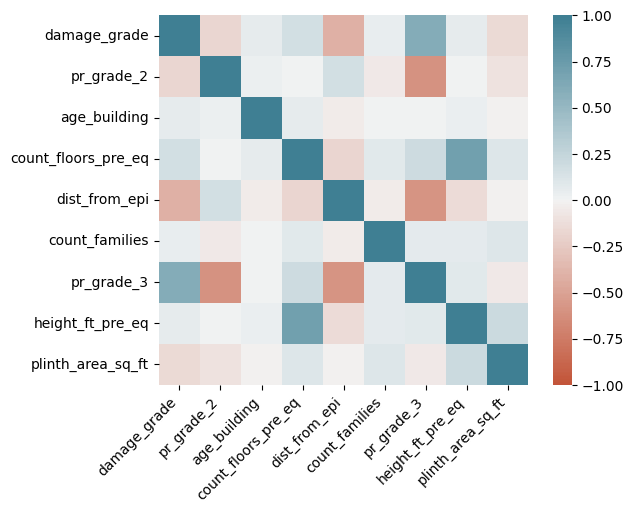

In [ ]:
#exploring useful features
# Names of different columns
import seaborn as sns

continuous_cols = ['count_floors_pre_eq', 'age_building', 'plinth_area_sq_ft',
       'height_ft_pre_eq', 'count_families',
       'pr_grade_2', 'pr_grade_3', 'dist_from_epi']
predictor_cols = list(set(data.columns)-set([y]))
categorical_cols = list(set(predictor_cols)-set(continuous_cols)) 

#correlation matrix for continuous features
corr = data[list(set(data.columns)-set(categorical_cols))].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Observation: Most of the variables are not highly predictive of the damage_grade.

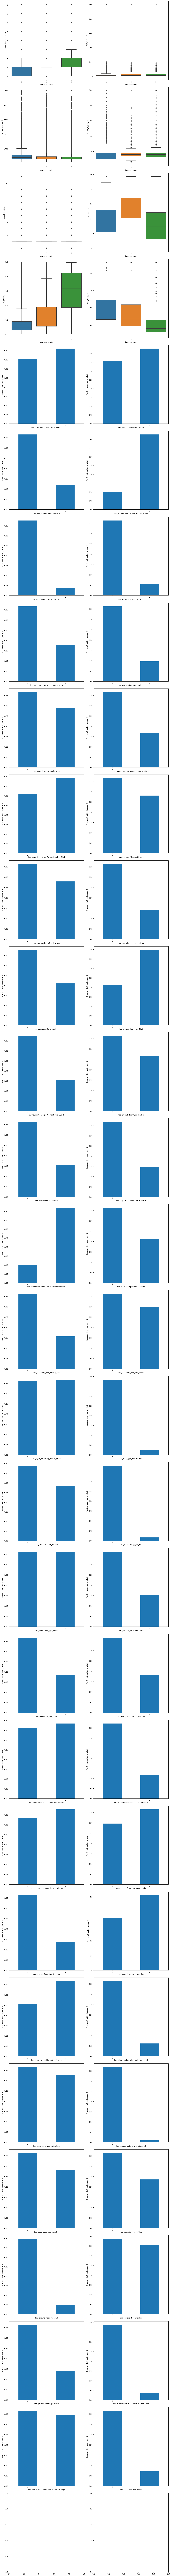

In [ ]:
# This is to plot everything in a 2x2 space
rows, cols = 30, 2
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(7*cols, 7*rows))
axs = axs.flatten()
posn = 0

#Plot continous features
for col in continuous_cols:
    sns.boxplot(data=data, y=col, x=y, ax=axs[posn])
    axs[posn].set_xlabel(y)
    axs[posn].set_ylabel(col)
    axs[posn].set_title("")
    posn += 1

#Plot categorical features for damage grade 3
def calc_frac(x):
  return (x[x==3].size)/(x.size)

for col in categorical_cols:
    data.groupby(col)[y].agg(calc_frac).plot(kind="bar", ax=axs[posn])
    axs[posn].set_ylabel("Fraction that had grade 3")
    posn += 1
    
plt.tight_layout()

In [ ]:
#removing columns that don't provide much information gain
data.drop(columns=['count_families', 'has_position_Not attached', 'has_foundation_type_Other', 'has_roof_type_Bamboo/Timber-Light roof', 'has_land_surface_condition_Steep slope', 'has_secondary_use_agriculture', 'has_land_surface_condition_Moderate slope', 'has_legal_ownership_status_Other'], inplace=True)

In [ ]:
print("Final modelling attributes along with target variable:\n\n")
print(data.dtypes)

Final modelling attributes along with target variable:


count_floors_pre_eq                             int64
age_building                                    int64
plinth_area_sq_ft                               int64
height_ft_pre_eq                                int64
has_superstructure_adobe_mud                    int64
has_superstructure_mud_mortar_stone             int64
has_superstructure_stone_flag                   int64
has_superstructure_cement_mortar_stone          int64
has_superstructure_mud_mortar_brick             int64
has_superstructure_cement_mortar_brick          int64
has_superstructure_timber                       int64
has_superstructure_bamboo                       int64
has_superstructure_rc_non_engineered            int64
has_superstructure_rc_engineered                int64
damage_grade                                    int64
has_secondary_use_hotel                         int64
has_secondary_use_rental                        int64
has_secondary_use_institu

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

%matplotlib inline

## **Splitting the dataset for training and testing**
---

In [ ]:
#splitting into training and test sets
from sklearn.model_selection import train_test_split
#shuffle data
data = data.sample(frac = 1)
Y = data[y]
X = data.drop(columns=[y])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.20, random_state=39)

## **Evaluation Functions**
---
We will use cumulative response (recall) for preliminary evaluation of models. Finally we will use both cumulative response and bad cost curve to choose the final model.

In [ ]:
def build_cumulative_curve(model, scale=100):
    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = model.predict_proba(X_test)[:, 2]

    # Sort theseprobabilities and the true value in descending order of probability
    order = np.argsort(Y_test_probability_1)[::-1]
    Y_test_probability_1_sorted = Y_test_probability_1[order]
    Y_test_sorted = np.array(Y_test)[order]

    # Build the cumulative response curve
    x_cumulative = np.arange(len(Y_test_probability_1_sorted)) + 1
    y_cumulative = np.cumsum(Y_test_sorted)

    # Rescale
    x_cumulative = np.array(x_cumulative)/float(x_cumulative.max()) * scale
    y_cumulative = np.array(y_cumulative)/float(y_cumulative.max()) * scale
    
    return x_cumulative, y_cumulative

def plot_cumulative_curve(models):
    # Plot curve for each model
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key])
        plt.plot(x_cumulative, y_cumulative, label=key)
    # Plot other details
    plt.plot([0,100], [0,100], 'k--', label="Random")
    plt.xlabel("Percentage of buildings targeted (decreasing score)")
    plt.ylabel("Percentage of positives targeted")
    plt.title("Cumulative response curve")
    plt.legend()

def plot_bad_cost_curve(models, scale=100):
    # Plot curve for each model
    total_obs = len(Y_test)
    total_pos = Y_test.sum()
    for key in models:
        #Get the probability of Y_test records being = 3
        Y_test_probability_1 = models[key].predict_proba(X_test)[:, 2]

        #cost of reconstruction will be proportional to a buildings height and plinth area
        Y_test_cost = X_test['plinth_area_sq_ft']*X_test['height_ft_pre_eq']
        # Sort theseprobabilities and the true value in descending order of probability
        order = np.argsort(Y_test_probability_1)[::-1]
        Y_test_probability_1_sorted = Y_test_probability_1[order]
        Y_test_sorted = np.array(Y_test)[order]
        Y_test_cost_sorted = np.array(Y_test_cost)[order]

        # Build the cumulative response curve
        x_cumulative = np.arange(len(Y_test_probability_1_sorted)) + 1
        y_cumulative_total = np.cumsum(Y_test_cost_sorted)
        y_cumulative_good = np.cumsum(np.multiply(Y_test_sorted, Y_test_cost_sorted))

        # Rescale
        x_cumulative = np.array(x_cumulative)/float(x_cumulative.max()) * scale #percentage of test instances target
        bad_cost = np.divide(y_cumulative_total - y_cumulative_good, y_cumulative_total) * 100

        #good_cost = unit_revenue * y_cumulative * total_pos - unit_cost * x_cumulative * total_obs
        plt.plot(x_cumulative, bad_cost, label=key)
    # Plot other details
    plt.xlabel("Percentage of buildings targeted  (decreasing score)")
    plt.ylabel("Bad Cost Rate")
    plt.title("Bad Cost Curve")
    plt.legend()

def get_vanilla_accuracy(models):
  for key in models:
    y_pred = models[key].predict(X_test)
    y_pred[y_pred != 3] = 0
    y_pred[y_pred == 3] = 1
    print('\nAccuracy for {}: {:.2f}\n'.format(key,accuracy_score(Y_test, y_pred)))


## **Exploring Logistic Regression**
---

In [ ]:
models = {}
for c in [0.001, 0.01, 0.05, .1, 1]:
    model = LogisticRegression(C=c, solver='liblinear')
    model.fit(X_train, Y_train)
    models["c = {}".format(c)] = model

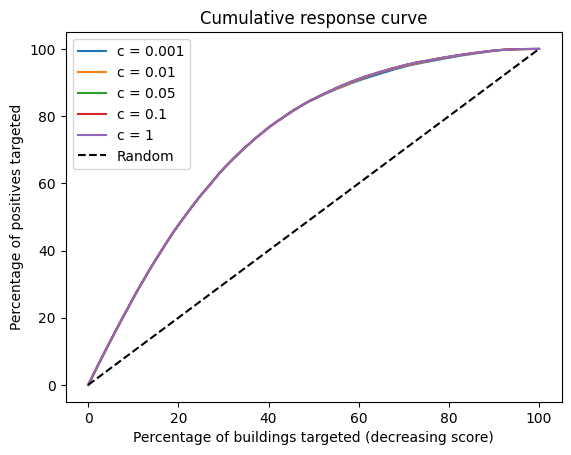

In [ ]:
#convert this into a binary class as we are only interested in damage grade 3 buildings
Y_test[Y_test != 3] = 0
Y_test[Y_test == 3] = 1
plot_cumulative_curve(models)

In [ ]:
#chose c = 0.01
best_lr_model = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, Y_train)

## **Exploring Decision Tree Classifiers**
---

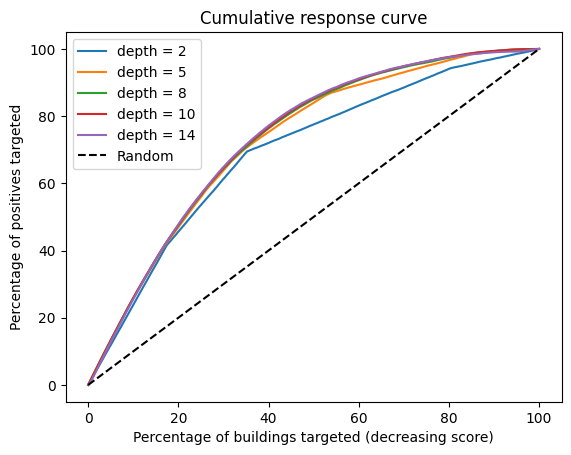

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

max_depths = [2,5,8,10,14]

models = {}

for depth in max_depths:
    model = DecisionTreeClassifier(max_depth= depth,random_state=42)
    model.fit(X_train,Y_train)
    models["depth = {}".format(depth)] = model

plot_cumulative_curve(models)

In [ ]:
#chose depth=8
best_dt_model = DecisionTreeClassifier(max_depth=8,random_state=42).fit(X_train, Y_train)

## **Exploring Random Forest Classifiers**
---





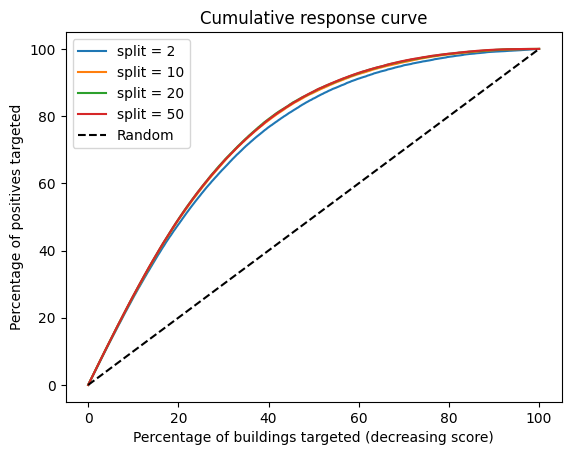

In [ ]:
min_splits = [2, 10, 20, 50]

models = {}

for split in min_splits: 
     model = RandomForestClassifier(min_samples_split=split, random_state=42)
     model.fit(X_train, Y_train)
     models["split = {}".format(split)] = model

plot_cumulative_curve(models)



In [ ]:
#chose split=10
best_rf_model = RandomForestClassifier(min_samples_split=10, random_state=42).fit(X_train, Y_train)

## **Final Set of Vanilla Accuracies**
---

In [ ]:
final_models = {"Logistic Regression": best_lr_model, "Decision Tree Classifier": best_dt_model, "Random Forest Classier": best_rf_model}
get_vanilla_accuracy(final_models)


Accuracy for Logistic Regression: 0.80


Accuracy for Decision Tree Classifier: 0.81


Accuracy for Random Forest Classier: 0.82



## **Final Set of Cumulative Response Curves**
---

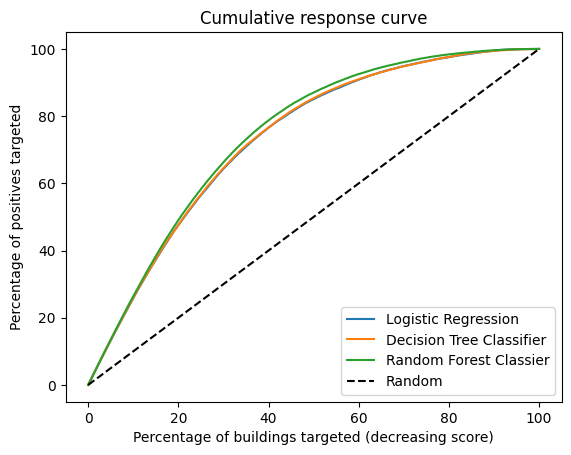

In [ ]:
plot_cumulative_curve(final_models)

## **Final Set of Bad Cost Curves**
---

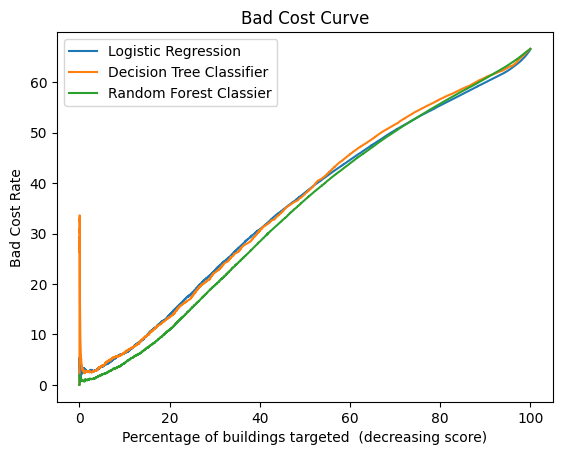

In [ ]:
plot_bad_cost_curve(final_models) 

## **Conclusion**
---
Random Forest Classifier performs either equivalent or slightly better for entire range of targeted percentage both in terms of recall and bad cost. However, Random Forest is also computationally heavy.

We suggest to chose the models based on available budget. If there is no defined budget, targeting the top ~40% of the buildings seems to provide a good balance between covering most of damage grade 3 buildings (about 80%) while wasting about 30% of the total budget. 